<h2>Analyzing Real Time Data Using New York City Bike Data</h2>

<p>Objective: Calculate the number of bikes available every minute for an hour across all of New York City. Activity is defined as the total number of bikes taken out or returned.</p>

<h3>Downloading the Data</h3>

In [ ]:
import requests # Requests is a package that allows downloading of data from any online source
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as lite
import time
import collections
from pandas.io.json import json_normalize
from dateutil.parser import parse 

%matplotlib inline

In [19]:
r = requests.get("http://www.citibikenyc.com/stations/json")
r.json()

{u'executionTime': u'2015-09-29 07:39:37 PM',
 u'stationBeanList': [{u'altitude': u'',
   u'availableBikes': 11,
   u'availableDocks': 28,
   u'city': u'',
   u'id': 72,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-09-29 07:39:01 PM',
   u'latitude': 40.76727216,
   u'location': u'',
   u'longitude': -73.99392888,
   u'postalCode': u'',
   u'stAddress1': u'W 52 St & 11 Ave',
   u'stAddress2': u'',
   u'stationName': u'W 52 St & 11 Ave',
   u'statusKey': 1,
   u'statusValue': u'In Service',
   u'testStation': False,
   u'totalDocks': 39},
  {u'altitude': u'',
   u'availableBikes': 14,
   u'availableDocks': 19,
   u'city': u'',
   u'id': 79,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-09-29 07:35:49 PM',
   u'latitude': 40.71911552,
   u'location': u'',
   u'longitude': -74.00666661,
   u'postalCode': u'',
   u'stAddress1': u'Franklin St & W Broadway',
   u'stAddress2': u'',
   u'stationName': u'Franklin St & W Broadway',
   u'statusKey': 1,
   u'statusValue': u'

In [20]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [21]:
# number of docks

len(r.json()['stationBeanList'])

508

In [22]:
# unique list of keys for each station listing

key_list = [] 
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)
print(key_list)

[u'availableDocks', u'totalDocks', u'city', u'altitude', u'stAddress2', u'longitude', u'lastCommunicationTime', u'postalCode', u'statusValue', u'testStation', u'stAddress1', u'stationName', u'landMark', u'latitude', u'statusKey', u'availableBikes', u'id', u'location']


In [23]:
df = json_normalize(r.json()['stationBeanList'])
print(df)

    altitude  availableBikes  availableDocks city    id landMark  \
0                         11              28         72            
1                         14              19         79            
2                         12              14         82            
3                         13              48         83            
4                         14              17        116            
5                          9              10        119            
6                          5              14        120            
7                         28               1        127            
8                          0              29        128            
9                          0              44        137            
10                         7              16        143            
11                         8              10        144            
12                         5              34        146            
13                        10              18    

<h3>Quick data exploration</h3>

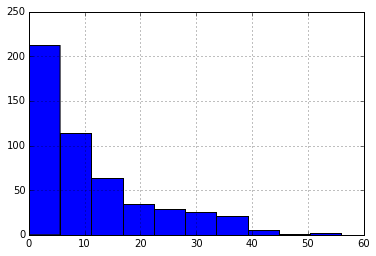

In [24]:
# available bikes

df['availableBikes'].hist()
plt.show()

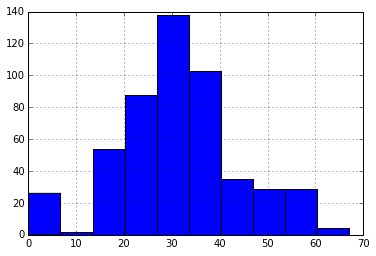

In [25]:
# total docks

df['totalDocks'].hist()
plt.show()

In [26]:
# mean of stations that are active 

condition = (df["statusValue"] == "In Service")
df[condition]["totalDocks"].mean()

32.74418604651163

In [27]:
# median of stations that are active; alternative syntax to above 

df[df["statusValue"] == "In Service"]["totalDocks"].median()

31.0

In [28]:
# store data into SQLite
# create table for available stations

con = lite.connect("citi_bike.db")
cur = con.cursor()

with con: 
    cur.execute("CREATE TABLE citibike_reference (id INT PRIMARY KEY, totalDocks INT, city TEXT, altitude INT, stAddress2 TEXT, longitude NUMERIC, postalCode TEXT, testStation TEXT, stAddress1 TEXT, stationName TEXT, landMark TEXT, latitude NUMERIC, location TEXT)")

# parameterized query
sql = "INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"

with con: 
    for station in r.json()["stationBeanList"]: 
        cur.execute(sql, (station["id"],station["totalDocks"],station["city"],station["altitude"],station["stAddress2"],station["longitude"],station["postalCode"],station["testStation"],station["stAddress1"],station["stationName"],station["landMark"],station["latitude"],station["location"]))



In [29]:
# create table for available bikes 

station_ids = df["id"].tolist()
station_ids = ["_" + str(x) + " INT" for x in station_ids]

with con: 
    cur.execute("CREATE TABLE available_bikes ( execution_time INT, " + ", ".join(station_ids) + ");")

    

In [ ]:
# get data for an hour and insert/update into available bike table created 

con = lite.connect("citi_bike.db")
cur = con.cursor()

for i in range(60): 
    r = requests.get("http://www.citibikenyc.com/stations/json")
    exec_time = parse(r.json()["executionTime"])  
    
    cur.execute("INSERT INTO available_bikes(execution_time) VALUES (?)", (exec_time.strftime("%s"),))
    con.commit()
    
    # create dictionary of station id and available bikes
    id_bikes = collections.defaultdict(int)
    for station in r.json()["stationBeanList"]: 
        id_bikes[station["id"]] = station["availableBikes"]
    
    # loop through id_bikes dictionary 
    for station_id, avail_bikes in id_bikes.iteritems(): 
    #   print k, v
        cur.execute("UPDATE available_bikes SET _" + str(station_id) + " = " + str(avail_bikes) + " WHERE execution_time = " + exec_time.strftime('%s') + ";")
    
    # pause the program for 60 seconds  
    time.sleep(60)

con.close()


<h3> Analyze the results</h3>

In [ ]:
con = lite.connect("citi_bike.db")
cur = con.cursor() 

def get_bikes():
    cur.execute("SELECT * FROM available_bikes")
    print(cur.fetchall())

get_bikes()

df = pd.read_sql_query("SELECT * FROM available_bikes ORDER BY execution_time",con,index_col="execution_time")
df